In [1]:
from models import *
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import copy
import os
import time


class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
    'chua',
]
names = [n + '1d' for n in names]

n_dim = 1
horizon = 10
N = 10000

N_h = 200
num_prepare = 0
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
nz = 100
connectivity = 1
reservoirConf = Dict(
    alpha=0.9,
    connectivity=1,
    nz=nz,
    nu=n_dim,
    target_rho=0.99,
    input_scale=1,
    #     activation = lambda x: 1/(1 + np.exp(-x))  # sigmoid
    #     activation = lambda x: np.maximum(0,x)
    #     activation = lambda x: x/(1 + np.exp(-x))
    activation=np.tanh
    #     activation = lambda x: np.sin(x)
)
path = 'result/recursive_multistep_prediction'
if not os.path.exists(path):
    os.makedirs(path)


def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        _, model_type, kwargs = conf
        model = model_type(**kwargs)
        model.train(x_train, y_train, num_prepare=num_prepare)
        Predictions = model.predict(x_test, num_prepare=num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model
    
    
for file in range(0,10):
    result_file = path + '/result_'+str(file) + '.csv'
    if os.path.exists(result_file):
        result = pd.read_csv(result_file)
    else:
        result = pd.DataFrame(columns=['datetime', 'system_name',  'n_dim', 'n_history', 'horizon', 'model_name', 'N_h', 'sigma','skip_con','encoder_type','nz', 'connectivity', 'mse'])

    process_start_time = time.time()
    print('开始数据处理')
    for system_name in names:
        for n_history in [20]:
        
            '''
            数据集
            '''
            x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
            x += np.random.randn(*x.shape)*0.001

            x_train = np.vstack([select_samples(x, train_start + i, num_train+num_prepare) for i in range(n_history)])
            y_train = select_samples(x, train_start+ num_prepare + n_history, num_train)
            x_test  = np.vstack([select_samples(x, test_start + i, num_test+num_prepare) for i in range(n_history)])
            y_test  = select_samples(x, test_start + num_prepare + n_history, num_test) 
            y_test_multi  = np.vstack([select_samples(x, test_start + num_prepare + n_history + i, num_test) 
                                for i in range(horizon)])

            rc = reservoirConf


            '''
            单步预测
            '''
            model_confs = []
            model_confs.append(
                [('ESN-transform', 
                ESN, 
                dict(reservoirConf=rc,encoder='transform',skip_con=n_history))]
            )

            model_confs.append(
                [('RBFLN-RE-transform', 
                RBFN_RE, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc, encoder='transform',skip_con=n_history)) 
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
            model_confs.append(
                [('ESN-ATTN-transform',
                ESN_ATTN, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc,encoder='transform',skip_con=n_history))
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
#             model_confs += [('RBFLN',ModelType.RBFLN, dict(N_h=N_h, sigma=sigma))
#                             for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             model_confs += [('RBFN',ModelType.RBFN, dict(N_h=N_h, sigma=sigma))
#                             for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             model_confs += [('VAR',ModelType.VAR, dict())]


            colors = list(cnames.keys())


            for j, confs in enumerate(model_confs):
            
                conf = select_model(confs)
                
                model_name, model_class, kwargs = conf
                print(model_name)

                model = model_class(**kwargs)
                model.train(x_train, y_train, num_prepare=num_prepare)
                pred = model.predict_multistep(x_test, horizon)
                
#                 plt.figure(figsize=(25,horizon+1))
#                 plt.subplot(horizon+1, 1, 1)
#                 plt.plot(x_test[-1])
#                 for i in range(horizon):
#                     plt.subplot(horizon+1,1,i+2)
#                     error = np.sum(np.square(pred[i*n_dim:(i+1)*n_dim,:] - y_test_multi[i*n_dim:(i+1)*n_dim,:]), axis=0)
# #                     print(len(error[error<1])/len(error))
#                     plt.plot(error)
#                 plt.show()
                error = np.sum(np.square(pred[-n_dim:,:] - y_test_multi[-n_dim:,:]), axis=0)
                print('{}% data within range'.format(len(error[error<1])/len(error)*100))
                if len(error[error<1])/len(error) < 0.9:
                    print('bad case for analysis, drop it')
                    continue
                mask = error<1
                MSE = [np.average(np.sum(np.square(pred[i*n_dim:(i+1)*n_dim,mask] - y_test_multi[i*n_dim:(i+1)*n_dim,mask]), axis=0)) for i in range(horizon)]
                print('MSE',MSE)

                for k in range(len(MSE)):
                    result.loc[result.shape[0]] = {
                        'datetime'          : pd.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                        'system_name'       : system_name,
                        'n_dim'             : n_dim,
                        'n_history'         : n_history,
                        'horizon'           : k+1,
                        'model_name'        : model_name,
                        'N_h'               : N_h,
                        'sigma'             : kwargs.get('sigma', 0),
                        'skip_con'          : kwargs.get('skip_con'),
                        'nz'                : nz,
                        'connectivity'      : connectivity,
                        'encoder_type'      : kwargs.get('encoder'),
                        'mse'               : MSE[k]
                    }
#                     print(result.loc[result.shape[0]-1])



    result.to_csv(result_file, index=False)

    print('结束数据处理')
    process_stop_time = time.time()

    # 差的时间戳
    diff_time = process_stop_time - process_start_time
    # 将计算出来的时间戳转换为结构化时间
    struct_time = time.gmtime(diff_time)
    # 减去时间戳最开始的时间 并格式化输出
    print('数据处理用了{0}年{1}月{2}日{3}小时{4}分钟{5}秒'.format(
        struct_time.tm_year - 1970,
        struct_time.tm_mon - 1,
        struct_time.tm_mday - 1,
        struct_time.tm_hour,
        struct_time.tm_min,
        struct_time.tm_sec
    ))

开始数据处理
ESN-transform
100.0% data within range
MSE [3.8082766002414123e-06, 9.031006595953586e-06, 1.9849945432108184e-05, 3.7795700026025265e-05, 6.398070864634181e-05, 9.893555578978216e-05, 0.0001487981135215286, 0.00021263382505316099, 0.0002899390326132688, 0.0003818000140501511]
RBFLN-RE-transform
100.0% data within range
MSE [4.45990805997871e-06, 1.1018146372865052e-05, 2.441245168471024e-05, 4.6952950287654326e-05, 8.005072544747058e-05, 0.00012558055697896065, 0.00018973831221041586, 0.0002720976001501979, 0.00037735016027288945, 0.0005084178283730256]
ESN-ATTN-transform
100.0% data within range
MSE [3.787374763011387e-06, 9.19161949913914e-06, 2.04104270003438e-05, 3.8241576565904566e-05, 6.212654686223018e-05, 8.954702940489875e-05, 0.0001244628125896668, 0.00016522680258855815, 0.00021069299208055668, 0.0002586120776668453]
ESN-transform
100.0% data within range
MSE [5.3300647326120605e-06, 1.671011397836252e-05, 4.003984762840988e-05, 8.03148427097326e-05, 0.00013923896222

100.0% data within range
MSE [4.643314007618601e-06, 1.2872972120747866e-05, 2.896277030094099e-05, 5.362355166789181e-05, 8.493727630457358e-05, 0.00012120295972135416, 0.0001640810229195443, 0.00020935957447432686, 0.0002571077421329715, 0.0003046708548570735]
ESN-transform
100.0% data within range
MSE [4.404455849441082e-06, 1.1060233532147912e-05, 2.153506439862851e-05, 3.5201523224136994e-05, 5.7679491898166366e-05, 9.595684916056244e-05, 0.00015327545524475178, 0.00023716412618069672, 0.00035341204136622327, 0.0005175276185004969]
RBFLN-RE-transform
100.0% data within range
MSE [3.704698029510282e-06, 8.354790574157984e-06, 1.6460195038961186e-05, 2.6933327499960766e-05, 4.125632675650781e-05, 6.309241891379388e-05, 9.423794342427075e-05, 0.00014262692593267382, 0.00021067115916708414, 0.00029278856164246815]
ESN-ATTN-transform
100.0% data within range
MSE [3.6809828828200396e-06, 8.222888774650934e-06, 1.5138511254069077e-05, 2.4231671665676232e-05, 3.95879946049741e-05, 6.55870

ESN-ATTN-transform
100.0% data within range
MSE [1.745580260361067e-05, 9.092965088164458e-05, 0.00025775395600058793, 0.0005345429597911746, 0.0009532059215165747, 0.0015385317344651522, 0.0023370959616956424, 0.0033709463539934818, 0.004619718186367754, 0.006064358953005256]
结束数据处理
数据处理用了0年0月0日0小时2分钟14秒
开始数据处理
ESN-transform
100.0% data within range
MSE [3.4814252349083087e-06, 8.412814431890074e-06, 1.933769267077603e-05, 3.805672711543445e-05, 6.446676719721848e-05, 9.739377646060409e-05, 0.00013713247688735435, 0.00018574159397675914, 0.00024378640748889494, 0.00031101329924606707]
RBFLN-RE-transform
100.0% data within range
MSE [3.86309477466713e-06, 9.466342402740271e-06, 1.9915430890232943e-05, 3.621839356635545e-05, 5.809261481826631e-05, 8.688912735557464e-05, 0.00012393154119127428, 0.00017121182323268574, 0.00023161195202845333, 0.00030682755597394204]
ESN-ATTN-transform
100.0% data within range
MSE [3.7087117407173607e-06, 9.646009649991498e-06, 2.3119377082223793e-05, 4.76

RBFLN-RE-transform
100.0% data within range
MSE [4.282568140686017e-06, 1.1804055237708561e-05, 3.0055535203279064e-05, 6.403808673551581e-05, 0.0001210247068523851, 0.00020344027945535403, 0.0003145413172830509, 0.00045504511797968196, 0.0006294058668305534, 0.0008386133223830517]
ESN-ATTN-transform
100.0% data within range
MSE [4.861965648877158e-06, 1.3964563156886142e-05, 3.2831796596355636e-05, 6.169033897182713e-05, 0.00010252771744374812, 0.00015545891691171122, 0.0002225142580828858, 0.0003036466646352076, 0.00039923322347127954, 0.0005082249727337689]
ESN-transform
100.0% data within range
MSE [4.620418411708408e-06, 1.2702027697003838e-05, 2.6869356758358552e-05, 4.755750257322226e-05, 8.201143797326966e-05, 0.0001433643298565887, 0.00025085634136108684, 0.00042722031827247133, 0.0007198148071333976, 0.0011633186583213662]
RBFLN-RE-transform
100.0% data within range
MSE [3.7542883241060796e-06, 9.451952625040474e-06, 2.121809126050203e-05, 3.890705200343836e-05, 6.51583367645

ESN-transform
100.0% data within range
MSE [2.517496467158735e-05, 0.00017447864916220136, 0.0005860897979895532, 0.0013342702180691095, 0.0024092931405109105, 0.003756354201802765, 0.005321688364215983, 0.007099224288874772, 0.009084225589137627, 0.011237718095920016]
RBFLN-RE-transform
100.0% data within range
MSE [5.311079887128544e-06, 1.7947493191261217e-05, 5.0228117543322265e-05, 0.00012350703004681778, 0.00026615066993420565, 0.0004935189259284446, 0.0008432951084041438, 0.0013453314713084204, 0.002041536033864756, 0.002918349275341607]
ESN-ATTN-transform
100.0% data within range
MSE [1.7237085462087695e-05, 9.276645445155095e-05, 0.0002772921249655267, 0.0005999113892186972, 0.0010743633636612505, 0.0017108483425335946, 0.002509787497519161, 0.0034869455734614432, 0.004652318346369103, 0.0060207265313604675]
结束数据处理
数据处理用了0年0月0日0小时2分钟15秒


# result analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime



system_names = ['lorentz','rossler','rabinovich_fabrikant','chua']
system_names = [system + '1d' for system in system_names]

path = 'result/recursive_multistep_prediction'
# path = 'result/direct_multistep_prediction'
result_file0 = path + '/result_0.csv' 
print(result_file0)
df = pd.read_csv(result_file0, index_col = 'datetime')
df.index = pd.DatetimeIndex(df.index)
print(set(df['model_name']))
df

result/recursive_multistep_prediction/result_0.csv
{'ESN-transform', 'RBFLN-RE-transform', 'ESN-ATTN-transform'}


,system_name,n_dim,n_history,horizon,model_name,N_h,sigma,skip_con,encoder_type,nz,connectivity,mse
datetime,,,,,,,,,,,,
2020-08-10 23:05:59,rossler1d,1,20,1,ESN-transform,200,0.000,20,transform,100,1,0.000004
2020-08-10 23:05:59,rossler1d,1,20,2,ESN-transform,200,0.000,20,transform,100,1,0.000009
2020-08-10 23:05:59,rossler1d,1,20,3,ESN-transform,200,0.000,20,transform,100,1,0.000020
2020-08-10 23:05:59,rossler1d,1,20,4,ESN-transform,200,0.000,20,transform,100,1,0.000038
2020-08-10 23:05:59,rossler1d,1,20,5,ESN-transform,200,0.000,20,transform,100,1,0.000064
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10 23:08:11,chua1d,1,20,6,ESN-ATTN-transform,200,0.125,20,transform,100,1,0.001932
2020-08-10 23:08:11,chua1d,1,20,7,ESN-ATTN-transform,200,0.125,20,transform,100,1,0.002845
2020-08-10 23:08:11,chua1d,1,20,8,ESN-ATTN-transform,200,0.125,20,transform,100,1,0.003966


lorentz1d
              mse     horizon
count  270.000000  270.000000
mean     0.000198    5.500000
std      0.000313    2.877615
min      0.000004    1.000000
25%      0.000021    3.000000
50%      0.000069    5.500000
75%      0.000218    8.000000
max      0.001876   10.000000


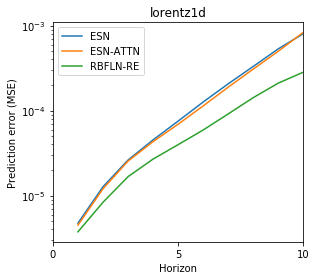

rossler1d
              mse     horizon
count  270.000000  270.000000
mean     0.000131    5.500000
std      0.000137    2.877615
min      0.000003    1.000000
25%      0.000021    3.000000
50%      0.000081    5.500000
75%      0.000209    8.000000
max      0.000647   10.000000


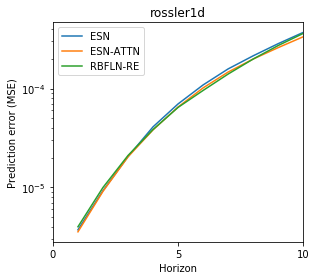

rabinovich_fabrikant1d
              mse     horizon
count  270.000000  270.000000
mean     0.000200    5.500000
std      0.000207    2.877615
min      0.000004    1.000000
25%      0.000032    3.000000
50%      0.000130    5.500000
75%      0.000314    8.000000
max      0.001018   10.000000


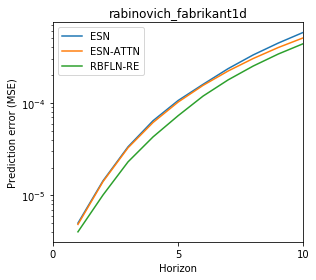

chua1d
              mse     horizon
count  270.000000  270.000000
mean     0.002514    5.500000
std      0.003256    2.877615
min      0.000005    1.000000
25%      0.000174    3.000000
50%      0.001233    5.500000
75%      0.003657    8.000000
max      0.014579   10.000000


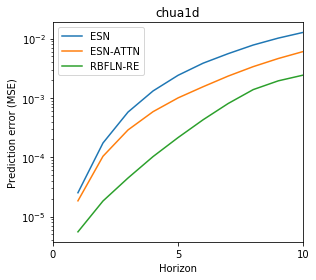

In [3]:
model_names = ['ESN-transform',  'ESN-ATTN-transform','RBFLN-RE-transform',]

for system_name in system_names:
    print(system_name)

    average = pd.DataFrame()
    for i in range(9):
        result_file = path + '/result_' +str(i) + '.csv' 
        df = pd.read_csv(result_file, index_col = 'datetime')
        df.index = pd.DatetimeIndex(df.index)

        result = df[df['system_name'].isin([system_name]) & 
                    df['model_name'].isin(model_names) & 
                    df['horizon'].isin(list(range(11))) &
                    df['skip_con'].isin([20])
                   ]


        final = None
        for w in set(result['horizon']):

            temp = result.loc[result['horizon'] == w, ['model_name', 'mse', 'horizon']].groupby('model_name').min().reset_index()

            final = temp if final is None else final.append(temp, ignore_index=True)

        average = average.append(final,ignore_index=True)
    print(average.describe())
    
    fig, ax = plt.subplots(figsize=(4.5,4))
    for name in model_names:
        average.loc[average['model_name'] == name].groupby('horizon').median().sort_values(by='horizon').plot(ax = ax)

    plt.legend(labels= ['ESN',  'ESN-ATTN','RBFLN-RE',], loc='upper left')
    ax.set_yscale("log")
#     ax.set_xscale("log")
    plt.xlabel('Horizon')
    plt.ylabel('Prediction error (MSE)')
    plt.xticks([0,5,10])
    plt.title(system_name)
    plt.tight_layout()

    plt.savefig(path+'/'+system_name+'_horizon.jpg')
    plt.show()

In [4]:
a = np.array([[1,2],[3,4]])
len(a[-3:])

2